In [1]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
from PIL import Image
from scipy.io import loadmat  
from scipy import stats  
from scipy.stats import multivariate_normal
import re
import glob
from operator import itemgetter 
import random

from support_functions import *

from keras.layers import Input, Dense
from keras.models import Model
from keras.models import load_model

Using TensorFlow backend.


## Read Data

In [3]:
label_1_folder = [9,21]      # Images in this folder will be labeled as anomaly
target_folders = range(1,22) # Read these folders
data_path = "CroppedYale/"   # Source folder

# Read image matrix (n*m), labels (vector of m), and image size
imgs, labels, height, width = get_data(label_1_folder,target_folders,data_path)

574  images are above our threshold and thus removed from the list


In [ ]:
def compile_autoencoder(data, data_length, n_components=32):
    '''
    Function to construct and compile the deep autoencoder, then return the model
    Input:
        - data: input data (images in a n*m matrix format)
        - data_length: size of each data point; used as the height 
        - n_components: number of components we want to keep in the decoded data
    '''
    # this is the size of our encoded representations
    encoding_dim = n_components  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

    # this is our input placeholder
    num_data = len(data)
    inputs = Input(shape=(data_length,))

    # "encoded" is the encoded representation of the input
    encoded = Dense(128, activation='relu')(inputs) 
    encoded = Dense(64, activation='relu')(encoded) 
    encoded = Dense(encoding_dim, activation='relu')(encoded)

    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(64, activation='relu')(encoded)
    decoded = Dense(128, activation='relu')(decoded) 
    decoded = Dense(img_size, activation='sigmoid')(decoded)

    # this model maps an input to its reconstruction
    autoencoder = Model(input_img, decoded)

    # this model maps an input to its encoded representation
    encoder = Model(input_img, encoded)

    # create a placeholder for an encoded (32-dimensional) input h
    #encoded_input = Input(shape=(encoding_dim,))
    # retrieve the last layer of the autoencoder model (one layer before the final reconstruction)
    #decoder_layer = autoencoder.layers[-3]
    # create the decoder model that maps an encoded input to its reconstruction
    #decoder = Model(encoded_input, decoder_layer(encoded_input))

    autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
    
    return autoencoder

In [5]:
autoencoder = load_model('model_autoencoder.h5')
# encoder = load_model('model_encoder.h5')

In [6]:
# Prepare the input
# Select only the Normal Image Dataset
imgs_normal = imgs[:,labels == 0]
# Split the images and labels
# By default: 80% in training and 20% in testing
train_ind, test_ind = perm_and_split(len(imgs_normal))
x_all = np.transpose(imgs_normal)
x_train = x_all[train_ind,:]
x_test = x_all[test_ind,:]

# Resize and reshape
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# Replicate in order to expand the size of the dataset 
x_train = np.tile(x_train, (200,1))
x_test = np.tile(x_test, (200,1))


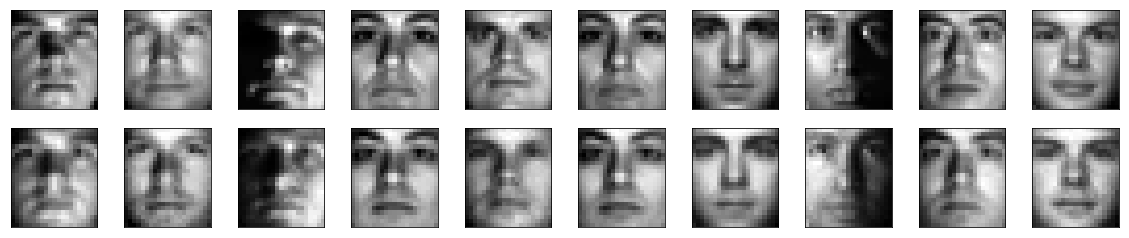

In [7]:
encoded_imgs = encoder.predict(x_test)
# decoded_imgs = decoder.predict(encoded_imgs)
decoded_imgs = autoencoder.predict(x_test)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(height, width))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display the encoded image
    # ax = plt.subplot(3, n, i + 1 + 2*n)
    # plt.imshow(encoded_imgs[i].reshape(height, width))
    # plt.gray()
    # ax.get_xaxis().set_visible(False)
    # ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(height, width))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
